My goal here is to make a bar plot showing copper content in tested yeast strains. Experiment was performed in triplicates, so means with indicated standard deviations will be presented. I will also perform statistical tests and if any differences between strains are significant, they will be shown in the plot. For statistics I use scipy.stats and pingouin – just to see if these modules perform the same and which one is easier to use.

In [26]:
# Importing modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg

In [27]:
# Defining function which allows changing the bar width in seaborn count plot.
# Solution proposed by jsgounot (https://stackoverflow.com/users/5016055/jsgounot).
def set_bar_width(ax, new_width):
    for patch in ax.patches:
        current_width = patch.get_width()
        patch.set_width(new_width)
        diff = current_width - new_width
        patch.set_x(patch.get_x() + diff * .5)

In [48]:
# Importing data from excel file to a dataframe.
copper_table = pd.read_excel('copper_iron_plasmids.xlsx')

Quick look at the dataframe.

In [29]:
copper_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Content  42 non-null     float64
 1   Element  42 non-null     object 
 2   Strain   42 non-null     object 
dtypes: float64(1), object(2)
memory usage: 736.0+ bytes


In [30]:
copper_table.head()

,Content,Element,Strain
0,30.284861,Copper,WT [-]
1,30.881279,Copper,WT [-]
2,31.737956,Copper,WT [-]
3,33.242222,Copper,vps13Δ [-]
4,37.846099,Copper,vps13Δ [-]


In [31]:
copper_table['Element'].unique()

array(['Copper', 'Iron'], dtype=object)

In [32]:
copper_table['Strain'].unique()

array(['WT [-]', 'vps13Δ [-]', 'vps13Δ [CTR1]', 'vps13Δ ccc2Δ [-]',
       'vps13Δ ccc2Δ [CTR1]', 'ctr1Δ [-]', 'fet3Δ [-]'], dtype=object)

I am interested in copper only, not in iron. Also, I do not need all the strains. For that, I do simple filtering to have a dataframe with copper only and desired strains.

In [40]:
select_element = copper_table['Element'] == 'Copper'
select_strains = copper_table['Strain'].isin(['WT [-]', 'vps13Δ [-]', 'vps13Δ [CTR1]', 'ctr1Δ [-]'])
copper_table_analysis = copper_table[(select_element) & (select_strains)]
copper_table_analysis

,Content,Element,Strain
0,30.284861,Copper,WT [-]
1,30.881279,Copper,WT [-]
2,31.737956,Copper,WT [-]
3,33.242222,Copper,vps13Δ [-]
4,37.846099,Copper,vps13Δ [-]
5,35.243748,Copper,vps13Δ [-]
6,65.977881,Copper,vps13Δ [CTR1]
7,66.546632,Copper,vps13Δ [CTR1]
8,68.768754,Copper,vps13Δ [CTR1]
15,30.526268,Copper,ctr1Δ [-]


Looks good. Now, let's do the statistics. I plan to use ANOVA followed by Tukey multiple comparson test in order to see if any strain is significantly different from others. I do not include values for ctr1Δ[-] strain - it serves as a negative control and can influence statistical differences between tested strains. 

I am going to use scipy.stat module to conduct statistical analysis. Then I will do the same using another python statistic library - pingouin and see how it works in comparison to scipy.

Before performing the tests, we need to check assumptions (normal distributions and homoscedasticity).

In [47]:
# Removing ctr1Δ [-] for hypothesis testing.
copper_statistics = copper_table_analysis[copper_table_analysis['Strain'] != 'ctr1Δ [-]']
copper_statistics['Strain'].unique()

array(['WT [-]', 'vps13Δ [-]', 'vps13Δ [CTR1]'], dtype=object)

In [42]:
# Shapiro-Wilk normality test in scipy.
# Checking if copper content in all categories (strain) is normally distributed.
print('Shapiro-Wilk results, scipy:')
for strain in copper_statistics['Strain'].unique():
    data = copper_statistics[copper_statistics['Strain'] == str(strain)]['Content']
    pvalue = round(stat.shapiro(data)[1],3)
    print('p_value for', strain, '=', pvalue)

Shapiro-Wilk results, scipy:
p_value for WT [-] = 0.803
p_value for vps13Δ [-] = 0.856
p_value for vps13Δ [CTR1] = 0.371


In [43]:
# Bartlett's test in scipy.
# Groups must be made manually.
wt = copper_statistics[copper_statistics['Strain'] == 'WT [-]']['Content']
vps13 = copper_statistics[copper_statistics['Strain'] == 'vps13Δ [-]']['Content']
vps13CTR1 = copper_statistics[copper_statistics['Strain'] == 'vps13Δ [CTR1]']['Content']

print("Bartlett's results, scipy:")
pvalue = round(stat.bartlett(wt, vps13, vps13CTR1)[1],3)
print('p_value =', pvalue)

Bartlett's results, scipy:
p_value = 0.395


Assumptions about normality and homoscedasticity are fullfiled. Time for hypothesis testing.

In [13]:
# One-way ANOVA in scipy
print('ANOVA, scipy:')
pvalue = stat.f_oneway(wt, vps13, vps13CTR1)[1]
print('p_value =', pvalue)

ANOVA, scipy:
p_value = 3.227826561431831e-07


Very low p-value (3.228 * 10<sup>-7</sup>) indicates that there are significant differences within tested groups. To find out which groups are different, I am going to perform Tukey's multiple comparison test. But there is a disappointment  - scipy.stats does not have this test... Going to use one from statsmodels.

In [44]:
tukey = pairwise_tukeyhsd(copper_statistics['Content'], copper_statistics['Strain'], alpha=0.05)
print(tukey)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1       group2    meandiff p-adj   lower   upper  reject
---------------------------------------------------------------
    WT [-]    vps13Δ [-]    4.476 0.0354  0.3801  8.5718   True
    WT [-] vps13Δ [CTR1]  36.1297  0.001 32.0339 40.2256   True
vps13Δ [-] vps13Δ [CTR1]  31.6537  0.001 27.5579 35.7496   True
---------------------------------------------------------------


We have an elegant table showing significant differences between all the groups. Looks good and clear, yet I would like to see the exactly p-value instead of values rounded to 0.001.

Now let's do the same in pingouin. According to pingouin documentation, test for normality and homoscedasticity in this library are taken from scipy.stats.

In [37]:
# Shapiro-Wilk normality test in pingouin.
pg.normality(data = copper_statistics, dv='Content', group='Strain', alpha=0.05)

AssertionError: Data must have more than 3 samples.

"Data must have more than 3 samples." Well, that's ridiculous. Very often, scientific experiments are performed in triplicates, like mine here. This means that pingouin normality test is useless in many cases...

In [38]:
# Bartlett's test in pingouin.
pg.homoscedasticity(data = copper_statistics, dv='Content', group='Strain', method='bartlett', alpha=0.05)

,T,pval,equal_var
bartlett,1.856607,0.395224,True


Interestingly, now 3 samples were enough. Test result is the same as in scipy.

In [46]:
# One-way ANOVA in pingouin.
pg.anova(data=copper_statistics, dv='Content', between='Strain')

,Source,ddof1,ddof2,F,p-unc,np2
0,Strain,2,6,434.338648,3.227827e-07,0.99314


Works nicely, p-value like in scipy.

In [45]:
# Tukey's test in pingouin.
pg.pairwise_tukey(data=copper_statistics, dv='Content', between='Strain')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,WT [-],vps13Δ [-],30.968032,35.444023,-4.475991,1.33646,-3.349139,0.035361,-2.187649
1,WT [-],vps13Δ [CTR1],30.968032,67.097756,-36.129724,1.33646,-27.033896,0.001000,-17.658467
2,vps13Δ [-],vps13Δ [CTR1],35.444023,67.097756,-31.653733,1.33646,-23.684756,0.001000,-15.470818


Results same like for statsmodels. Again, no exact p-values were given if they are very low.

Overall, both modules worked the same, yet data is easier to introduce into pinguin functions, no need to manually creating data groups. However, I believe that the requirement of at least 4 samples for normality test should be corrected.

For confirmation, I performed same analysis using R, they yield the same results.

Time to do the plot showing our data. Means of copper content for each strain with indicated standard deviation will be shown in a bar plot. Statistical significances will also be presented: * for p-value <0.05, *** for p-values < 0.001.

Significant differences were indicated in the plot using solution proposed by Ulrich Stern.
(https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values-into-matplotlib/37518947#37518947)

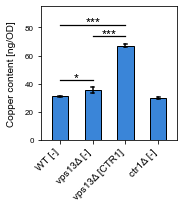

In [39]:
plt.rcParams["font.family"] = "arial"
fig, ax = plt.subplots()
fig.set_size_inches([2.7, 3])
ax = sns.barplot(x='Strain', y='Content', data=copper_table_analysis, ci='sd', color='#2084F2',
                edgecolor='#000000', linewidth=1, errwidth=1.5, capsize=0.1, errcolor='#000000')
set_bar_width(ax, 0.5)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=45, ha='right')
ax.set_ylabel('Copper content [ng/OD]', fontsize=10)
ax.set_ylim(0,95)
ax.set_yticklabels(list(range(0,91,20)), fontsize=8)
ax.yaxis.set_label_coords(-0.18, 0.5)

sig1 = copper_table_analysis[copper_table_analysis['Strain']=='vps13Δ [-]']['Content'].mean()
sig2 = copper_table_analysis[copper_table_analysis['Strain']=='vps13Δ [CTR1]']['Content'].mean()
x1, x2 = 0, 1
y = sig1 + 7
plt.plot([x1,x2], [y,y], linewidth=1.25, color='#000000')
plt.text((x1+x2)*0.5, y-1.5, "*", ha='center', fontsize=13)

x1, x2 = 1, 2
y = sig2 + 7
plt.plot([x1,x2], [y,y], linewidth=1.25, color='#000000')
plt.text((x1+x2)*0.5, y-1.5, "***", ha='center', fontsize=13)

x1, x2 = 0, 2
y = sig2 + 15
plt.plot([x1,x2], [y,y], linewidth=1.25, color='#000000')
plt.text((x1+x2)*0.5, y-1.5, "***", ha='center', fontsize=13)
plt.tight_layout()
fig.savefig('images/copper_content.png', dpi=600)
plt.show()

Looks nice. Just labels will be edited - some (but only some) parts must be italicized according to gene naming convention. This will require a lot of coding (if it's possible at all to do in Python?), so it's easier to do by manually in a graphics editing program.